In [ ]:
# This notebook uses publicly available football event data provided by:
#
#   StatsBomb Open Data
#   https://github.com/statsbomb/open-data

# West Ham United Passing Network — Full-Season Analysis (2015–16) Premier League

### *Advanced Player Influence Metrics, Progression Analysis & PCA Role Clustering*

**Data Source:** StatsBomb Open Data  
**Scope:** All WHU Premier League matches (2015–16 Season)  
**Techniques:** Graph Theory, Centrality Metrics, Event Data Processing, PCA  
**Outputs:** Player influence profiles, season summary table, role clusters  

---

This notebook processes match-by-match StatsBomb JSON files, builds directed weighted passing networks for each game, computes multiple centrality-based influence metrics, aggregates results across the season, and applies PCA to uncover underlying tactical roles within the squad.

---

# Table of Contents

1. Introduction

2. Import Libraries & Setup

3. Match List & Automated Event Download

4. Event Processing Pipeline

5. Passing Network Construction

6. Season Summary (Aggregated Metrics)

7. Top 3 Players Progression Analysis

8. Dimensionality Reduction & Clustering

9. Conclusion & Next Steps

---

# 1. Introduction

##  Motivation
Passing networks are one of the most powerful tools in football analytics for quantifying **how a team plays**, **which players carry influence**, and **how responsibilities are shared** across the pitch.  
This notebook focuses on West Ham United’s 2015–16 Premier League season, extracting match data from StatsBomb to build repeatable, interpretable analytics outputs for every player and every match.

## Dataset Description
We use event-level data from the **StatsBomb Open Data** repository, including:
- Pass events with locations
- Shots
- Possession data
- Player + team metadata

A list of match IDs is provided, and all event JSON files are downloaded automatically.

## Key Questions
This analysis aims to answer:
1. **Which WHU players carried the most influence in possession?**  
   (degree, betweenness, eigenvector centrality)

2. **Which players progressed play most effectively?**  
   (progressive passes, pressure actions)

3. **How were players involved in xG-chain or goal-chain sequences?**  
   (build-up to goals)

4. **Can we summarize player roles over the season using data?**  
   (PCA on passing-network features)

---

# Methodology Overview

1. **Event Extraction**  
   For each match, we parse the JSON file and extract:
   - Completed passes
   - Passer/receiver IDs
   - Start/end locations
   - Progressive pass flags
   - Led-to-goal indicators

2. **Edge Aggregation**  
   For every passer → receiver pair we compute:
   - Pass count  
   - Progressive pass count  
   - Goal-chain count  
   - Assist count  
   - Composite edge weight (explaining functional importance)

3. **Passing Network Construction**  
   We build a directed weighted graph using NetworkX.

4. **Centrality Analysis**  
   We compute:
   - **Degree centrality** → involvement
   - **Betweenness centrality** → playmaking responsibility
   - **Closeness centrality** → connectivity
   - **Eigenvector centrality** → quality of connections  
   These map well to real scouting concepts.

5. **Season Aggregation**  
   Each player's match-level metrics are merged with minutes played and event counts to produce:
   - Total metrics  
   - Per-90 metrics  
   - Season influence profiles

6. **PCA Role Clustering**  
   To identify role archetypes (e.g., deep playmaker, connector, progressor), we standardize player metrics and apply PCA:
   - Reduce to 2D space  
   - Visualize clusters  
   - Interpret tactical roles

---

This methodology provides a complete, reproducible workflow for deriving player influence profiles, match impact patterns, and role archetypes from raw event data.

# 2. Import Libraries & Setup

In [1]:
import os
import json
import math
import requests
from pathlib import Path
import pandas as pd
import networkx as nx
from datetime import datetime

# ----------------- CONFIG
TEAM_NAME = "West Ham United"
PITCH_W, PITCH_H = 120, 80
GOAL_X, GOAL_Y = 120, 40
PROG_THRESH = 0.25

DATA_DIR = Path("matches")
DATA_DIR.mkdir(exist_ok=True)

Helpers

In [2]:
def is_pass(e): return e.get("type",{}).get("name") == "Pass"
def completed(e): return "pass" in e and e["pass"].get("outcome") is None
def is_team(e, name): return e.get("team",{}).get("name") == name

def dist(a,b): return math.hypot(a[0]-b[0], a[1]-b[1])

def progressive(sx,sy,ex,ey, gx=GOAL_X, gy=GOAL_Y, thresh=PROG_THRESH):
    if None in (sx,sy,ex,ey): return False
    sd, ed = dist((sx,sy),(gx,gy)), dist((ex,ey),(gx,gy))
    if sd == 0: return False
    return ed <= (1-thresh)*sd

def shot_goal(e):
    return (
        e.get("type",{}).get("name") == "Shot" and
        e.get("shot",{}).get("outcome",{}).get("name") == "Goal"
    )

def get_xy(e):
    loc = e.get("location")
    return (loc[0], loc[1]) if loc else (None, None)

def get_end_xy(e):
    loc = e.get("pass",{}).get("end_location")
    return (loc[0], loc[1]) if loc else (None, None)

# 3. Match List & Automated Event Download

In [6]:
matches_meta = pd.DataFrame({
    "match_id":[3754141,3754203,3754131,3753984,3754329,3754077,3754323,3754076,
                3754067,3754288,3754273,3754194,3754109,3754235,3754347,3754096,
                3754259,3754285,3753998,3754251,3754021,3754338,3753997,3754086,
                3754110,3754120,3754244,3754331,3754349,3754277,3753973,3754176,
                3754241,3754227,3754134,3754192,3754158,3754199],
    "match_date":[
        "2015-08-09","2015-08-15","2015-08-22","2015-08-29","2015-09-14","2015-09-19",
        "2015-09-26","2015-10-03","2015-10-17","2015-10-24","2015-10-31","2015-11-07",
        "2015-11-22","2015-11-29","2015-12-05","2015-12-12","2015-12-20","2015-12-26",
        "2015-12-28","2016-01-02","2016-01-12","2016-01-16","2016-02-02","2016-04-20",
        "2016-01-23","2016-02-06","2016-02-13","2016-02-27","2016-03-02","2016-03-05",
        "2016-03-19","2016-04-02","2016-04-09","2016-04-17","2016-05-10","2016-04-30",
        "2016-05-07","2016-05-15"],
    "home_team":["Arsenal", "West Ham United", "West Ham United", "Liverpool", "West Ham United",
                 "Manchester City", "West Ham United", "Sunderland", "Crystal Palace", "West Ham United",
                 "Watford", "West Ham United", "Tottenham Hotspur", "West Ham United", "Manchester United",
                 "West Ham United", "Swansea City", "Aston Villa", "West Ham United", "West Ham United",
                 "AFC Bournemouth", "Newcastle United", "West Ham United", "West Ham United", "West Ham United",
                 "Southampton", "Norwich City", "West Ham United", "West Ham United", "Everton", "Chelsea",
                 "West Ham United", "West Ham United", "Leicester City", "West Ham United", "West Bromwich Albion",
                 "West Ham United", "Stoke City"],
    "away_team":["West Ham United", "Leicester City", "AFC Bournemouth", "West Ham United", "Newcastle United",
                 "West Ham United", "Norwich City", "West Ham United", "West Ham United", "Chelsea",
                 "West Ham United", "Everton", "West Ham United", "West Bromwich Albion", "West Ham United",
                 "Stoke City", "West Ham United", "West Ham United", "Southampton", "Liverpool", "West Ham United",
                 "West Ham United", "Aston Villa", "Watford", "Manchester City", "West Ham United", "West Ham United",
                 "Sunderland", "Tottenham Hotspur", "West Ham United", "West Ham United", "Crystal Palace", "Arsenal",
                 "West Ham United", "Manchester United", "West Ham United", "Swansea City", "West Ham United"]
})

matches_meta["date"] = pd.to_datetime(matches_meta["match_date"])

Download all match files

In [4]:
def download_match(mid):
    url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{mid}.json"
    out = DATA_DIR / f"{mid}.json"

    if out.exists():
        return out  # skip if already downloaded

    r = requests.get(url)
    if r.status_code != 200:
        print(f"❌ Failed to download match {mid}")
        return None

    out.write_text(r.text, encoding="utf-8")
    print(f"✔ Downloaded {mid}")
    return out

# 4. Event Processing Pipeline

In [8]:
def process_match(mid, meta):
    # Load JSON
    fpath = DATA_DIR / f"{mid}.json"
    events = json.loads(Path(fpath).read_text(encoding="utf-8"))

    rows = []
    for i, e in enumerate(events):
        if not (is_pass(e) and is_team(e, TEAM_NAME) and completed(e)):
            continue
        if "player" not in e or "pass" not in e or "recipient" not in e["pass"]:
            continue

        passer_id = e["player"]["id"]
        passer = e["player"]["name"]
        recv_id = e["pass"]["recipient"]["id"]
        recv = e["pass"]["recipient"]["name"]

        sx, sy = get_xy(e)
        ex, ey = get_end_xy(e)
        possession = e.get("possession")
        length = e["pass"].get("length")
        under_press = bool(e.get("under_pressure", False))
        assist_flag = bool(e["pass"].get("goal_assist") or e["pass"].get("assisted_shot_id"))

        prog = progressive(sx, sy, ex, ey)

        # xG-chain + goal-scoring involvement
        xg_chain = 0.0
        led_to_goal = False

        for j in range(i+1, len(events)):
            fwd = events[j]
            if fwd.get("possession") != possession:
                break
            if fwd.get("team",{}).get("name") != TEAM_NAME:
                break

            if fwd.get("type",{}).get("name") == "Shot":
                xg = fwd.get("shot",{}).get("statsbomb_xg")
                if xg is not None:
                    xg_chain += float(xg)

            if fwd.get("player",{}).get("id") == recv_id and shot_goal(fwd):
                led_to_goal = True

        rows.append({
            "passer_id": passer_id,
            "passer": passer,
            "receiver_id": recv_id,
            "receiver": recv,
            "sx": sx, "sy": sy,
            "ex": ex, "ey": ey,
            "length": length,
            "under_pressure": under_press,
            "progressive": prog,
            "led_to_goal": led_to_goal,
            "assist": assist_flag,
            "xg_chain_value": xg_chain
        })

    passes = pd.DataFrame(rows)
    if passes.empty:
        print(f"⚠ No completed passes for WHU in match {mid}")
        return pd.DataFrame()

    # EDGE aggregation
    edges = (
        passes.groupby(["passer_id","passer","receiver_id","receiver"], as_index=False)
              .agg(
                   passes=("receiver_id","count"),
                   progressive=("progressive","sum"),
                   goal_chain=("led_to_goal","sum"),
                   assists=("assist","sum"),
                   under_pressure=("under_pressure","sum"),
              )
    )

    # Build graph
    G = nx.DiGraph()
    for _, r in edges.iterrows():
        u = (r.passer_id, r.passer)
        v = (r.receiver_id, r.receiver)
        if not G.has_node(u): G.add_node(u, label=r.passer)
        if not G.has_node(v): G.add_node(v, label=r.receiver)
        G.add_edge(
            u, v,
            weight=float(r.passes + 0.5*r.progressive + 3*r.goal_chain + 2*r.assists),
            passes=int(r.passes),
            progressive=int(r.progressive),
            goal_chain=int(r.goal_chain),
            assists=int(r.assists),
            under_pressure=int(r.under_pressure)
        )

    # Centralities
    deg = nx.degree_centrality(G.to_undirected())
    lengths = {(u,v): 1.0/d['weight'] for u,v,d in G.edges(data=True)}
    nx.set_edge_attributes(G, lengths, name="length")

    bet = nx.betweenness_centrality(G, weight="length", normalized=True)
    close = nx.closeness_centrality(G, distance="length")
    try:
        # Try global eigenvector centrality
        eig = nx.eigenvector_centrality_numpy(G, weight="weight")

    except nx.AmbiguousSolution:
        print("Graph is disconnected — selecting a strongly connected component.")

        if G.is_directed():
            # must use *strongly* connected components
            scc = list(nx.strongly_connected_components(G))
            # pick the largest strongly connected component
            largest = max(scc, key=len)
        else:
            # normal connected components for undirected
            largest = max(nx.connected_components(G), key=len)

        H = G.subgraph(largest).copy()
        eig = nx.eigenvector_centrality_numpy(H, weight="weight")

    # Create final rows per player
    out = []
    for n in G.nodes():
        pid, name = n
        # Count pass-based stats
        p_df = passes[(passes["passer_id"] == pid) | (passes["receiver_id"] == pid)]

        out.append({
            "match_id": mid,
            "date": meta["date"],
            "home_team": meta["home_team"],
            "away_team": meta["away_team"],
            "player_id": pid,
            "player": name,

            # Centralities
            "degree_centrality": deg.get(n, 0),
            "betweenness": bet.get(n, 0),
            "closeness": close.get(n, 0),
            "eigenvector": eig.get(n, 0),

            # Raw counts
            "passes": len(passes[passes["passer_id"] == pid]),
            "progressive_passes": passes[passes["passer_id"] == pid]["progressive"].sum(),
            "under_pressure_passes": passes[passes["passer_id"] == pid]["under_pressure"].sum(),
            "led_to_goal": passes[passes["passer_id"] == pid]["led_to_goal"].sum(),
            "assists": passes[passes["passer_id"] == pid]["assist"].sum(),
            "xg_chain_total": passes[passes["passer_id"] == pid]["xg_chain_value"].sum()
        })

    return pd.DataFrame(out)

# 5. Passing Network Construction

Run full pipeline

In [15]:
all_results = []

for _, row in matches_meta.iterrows():
    mid = row["match_id"]

    # download
    download_match(mid)

    # process
    df_game = process_match(mid, {
        "date": row["date"],
        "home_team": row["home_team"],
        "away_team": row["away_team"]
    })

    if not df_game.empty:
        all_results.append(df_game)

final_df = pd.concat(all_results, ignore_index=True)

Graph is disconnected — selecting a strongly connected component.
Graph is disconnected — selecting a strongly connected component.
Graph is disconnected — selecting a strongly connected component.
Graph is disconnected — selecting a strongly connected component.
Graph is disconnected — selecting a strongly connected component.
Graph is disconnected — selecting a strongly connected component.


Save output

In [16]:
final_df.to_csv("west_ham_passing_metrics.csv", index=False)

print("Saved west_ham_passing_metrics.csv")

Saved west_ham_passing_metrics.csv


In [17]:
from sklearn.preprocessing import MinMaxScaler

# columns to normalize
cols = [
    "degree_centrality",
    "betweenness",
    "closeness",
    "eigenvector",
    "passes",
    "progressive_passes",
    "under_pressure_passes",
    "led_to_goal",
    "assists",
    "xg_chain_total"
]

scaler = MinMaxScaler(feature_range=(0, 1))

# fit + transform only the selected columns
final_df[cols] = scaler.fit_transform(final_df[cols])

In [18]:
final_df.to_csv("west_ham_passing_metrics_normalized.csv", index=False)

print("Saved west_ham_passing_metrics_normalized.csv")

Saved west_ham_passing_metrics_normalized.csv


In [20]:
final_df = pd.read_csv("west_ham_passing_metrics.csv")
final_df_norm = pd.read_csv("west_ham_passing_metrics_normalized.csv")

# 6. Season Summary (Aggregated Metrics)

Player Season Aggregates (mean + sum)

In [21]:
# Season totals & averages per player
season_player_summary = (
    final_df
    .groupby(["player_id", "player"])
    .agg(
        matches_played=("match_id", "nunique"),
        avg_degree=("degree_centrality", "mean"),
        avg_betweenness=("betweenness", "mean"),
        avg_closeness=("closeness", "mean"),
        avg_eigenvector=("eigenvector", "mean"),

        total_passes=("passes", "sum"),
        total_progressive=("progressive_passes", "sum"),
        total_under_pressure=("under_pressure_passes", "sum"),
        total_led_to_goal=("led_to_goal", "sum"),
        total_assists=("assists", "sum"),
        total_xg_chain=("xg_chain_total", "sum")
    )
    .reset_index()
    .sort_values("avg_eigenvector", ascending=False)
)

### Proposed Final Meta-Metric: Player Influence Index (PII)

(Weighted composite of structural influence + productive actions)

Formula:

`PII = 0.5 × Network Influence + 0.5 × On-ball Impact`

Where:

#### **A) Network Influence (structural metrics)**

All scaled 0–1 already:



```
NI =
  0.30 * avg_eigenvector +
  0.30 * avg_betweenness +
  0.20 * avg_degree +
  0.20 * scaled_closeness
```

Reasoning:

- Eigenvector and betweenness represent the highest tactical importance, so the heaviest weights.

- Degree = involvement → secondary

- Closeness helps cohesive play → secondary (scaled)

#### **B) On-ball Impact Score**

All inputs scaled to 0–1 first (min-max or robust scaler):



```
OI =
  0.25 * scaled_passes +
  0.20 * scaled_progressive +
  0.15 * scaled_under_pressure +
  0.20 * scaled_xg_chain +
  0.10 * scaled_assists +
  0.10 * scaled_led_to_goal
```


Reasoning:

- Pass volume is important → 0.25

- Progressive & press-resistant actions matter → 0.20 + 0.15

- xG-chain is very high value → 0.20

- Assists + goal-chain actions are rare but decisive → balanced at 0.10 each

Why this metric could be good

- ✔ Scales heterogeneous features properly
- ✔ Balances network structure with on-ball productivity
- ✔ Produces rankings similar to expert intuition
- ✔ Not dominated by passes
- ✔ Gives offensive + defensive midfielders fair treatment
- ✔ Directly interpretable for scouts

In [23]:
df = season_player_summary.copy()

# ---- 1) Scale event-based metrics ----
to_scale = [
    "total_passes",
    "total_progressive",
    "total_under_pressure",
    "total_led_to_goal",
    "total_assists",
    "total_xg_chain",
    "avg_closeness"   # closeness is structurally larger than others
]

scaler = MinMaxScaler()
df[[c + "_scaled" for c in to_scale]] = scaler.fit_transform(df[to_scale])

# ---- 2) Network Influence ----
df["network_influence"] = (
    0.30 * df["avg_eigenvector"] +
    0.30 * df["avg_betweenness"] +
    0.20 * df["avg_degree"] +
    0.20 * df["avg_closeness_scaled"]
)

# ---- 3) On-ball Impact ----
df["onball_impact"] = (
    0.25 * df["total_passes_scaled"] +
    0.20 * df["total_progressive_scaled"] +
    0.15 * df["total_under_pressure_scaled"] +
    0.20 * df["total_xg_chain_scaled"] +
    0.10 * df["total_assists_scaled"] +
    0.10 * df["total_led_to_goal_scaled"]
)

# ---- 4) Final Player Influence Index ----
df["PII"] = 0.5 * df["network_influence"] + 0.5 * df["onball_impact"]

# ---- Sort ranking ----
df_ranked = df.sort_values("PII", ascending=False).reset_index(drop=True)

df_ranked[[
    "player", "PII",
    "network_influence", "onball_impact",
    "avg_eigenvector", "avg_betweenness",
    "total_passes", "total_xg_chain"
]].head(15)

,player,PII,network_influence,onball_impact,avg_eigenvector,avg_betweenness,total_passes,total_xg_chain
0,Dimitri Payet,0.713855,0.570738,0.856972,0.424811,0.244485,1103,10.399284
1,Mark Noble,0.623841,0.535762,0.711920,0.357598,0.225351,1662,5.570137
2,Aaron Cresswell,0.541075,0.475436,0.606714,0.319781,0.151485,1402,3.474899
3,Manuel Lanzini,0.460983,0.503721,0.418244,0.370776,0.156128,969,5.251096
4,Cheikhou Kouyaté,0.384649,0.434176,0.335123,0.283120,0.072935,998,2.005838
5,Michail Antonio,0.327951,0.403903,0.251999,0.264179,0.060744,460,1.642119
6,James Tomkins,0.313905,0.367079,0.260731,0.203025,0.093774,747,0.774476
7,Winston Reid,0.286702,0.357848,0.215556,0.190878,0.044932,691,0.735716
8,Angelo Obinze Ogbonna,0.285601,0.350358,0.220844,0.194616,0.068713,759,0.195583
9,Andy Carroll,0.277969,0.371576,0.184363,0.220850,0.041131,266,2.092757


# 7. Top 3 Players Progression Analysis

In [31]:
import seaborn as sns

In [32]:
top3_players = (
    df_ranked
    .sort_values("PII", ascending=False)
    .head(3)["player"]
    .tolist()
)

print("Top 3 players:", top3_players)

Top 3 players: ['Dimitri Payet', 'Mark Noble', 'Aaron Cresswell']


In [43]:
# Define metric groups
network_metrics = ["degree_centrality", "betweenness", "closeness", "eigenvector"]
impact_metrics  = ["passes", "progressive_passes", "under_pressure_passes",
                   "assists", "xg_chain_total", "led_to_goal"]

# WHU color palettes
struct_colors = {
    "degree_centrality":   "#7A263A",
    "betweenness":         "#1BB1E7",
    "closeness":           "#F3D459",
    "eigenvector":         "#C4CED4",
}

impact_colors = {
    "passes":                "#7A263A",
    "progressive_passes":    "#1BB1E7",
    "under_pressure_passes": "#F3D459",
    "assists":               "#C4CED4",
    "xg_chain_total":        "#A26EFF",
    "led_to_goal":           "#FF8F00",
}

sns.set_theme(style="whitegrid")

In [44]:
def plot_player_timeseries(df, player, network_metrics, impact_metrics,
                           struct_colors, impact_colors):
    """
    Plot two time-series charts for a player's season:
    (1) Network Influence metrics
    (2) On-ball Impact metrics

    Parameters
    ----------
    df : pd.DataFrame
        Season match-by-match dataframe.
    player : str
        Name of the player to visualize.
    network_metrics : list
        Metrics representing structural network influence.
    impact_metrics : list
        Metrics representing on-ball impact.
    struct_colors : dict
        Color mapping for network metrics.
    impact_colors : dict
        Color mapping for impact metrics.
    """

    # Filter season data for this player
    sub = (
        df[df["player"] == player]
        .sort_values("date")
        .copy()
    )

    # Melt for seaborn long format
    net_long = sub.melt(
        id_vars=["date"],
        value_vars=network_metrics,
        var_name="metric",
        value_name="value"
    )

    impact_long = sub.melt(
        id_vars=["date"],
        value_vars=impact_metrics,
        var_name="metric",
        value_name="value"
    )

    # ------------------ PLOT ------------------
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # 1) Structural Network Influence
    sns.lineplot(
        data=net_long, x="date", y="value",
        hue="metric", palette=struct_colors,
        marker="o", linewidth=2, ax=axes[0]
    )
    axes[0].set_title(f"{player} – Network Influence over Season", fontsize=14)
    axes[0].set_ylabel("Normalized value")
    axes[0].legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")

    # 2) On-ball Impact
    sns.lineplot(
        data=impact_long, x="date", y="value",
        hue="metric", palette=impact_colors,
        marker="o", linewidth=2, ax=axes[1]
    )
    axes[1].set_title(f"{player} – On-ball Impact over Season", fontsize=14)
    axes[1].set_ylabel("Normalized value")
    axes[1].set_xlabel("Match date")
    axes[1].legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")

    # Beautify dates
    for ax in axes:
        ax.tick_params(axis="x", rotation=45)

    plt.suptitle(f"West Ham United – {player} Time Series Profile", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

## Progression Analysis for Dimitri Payet

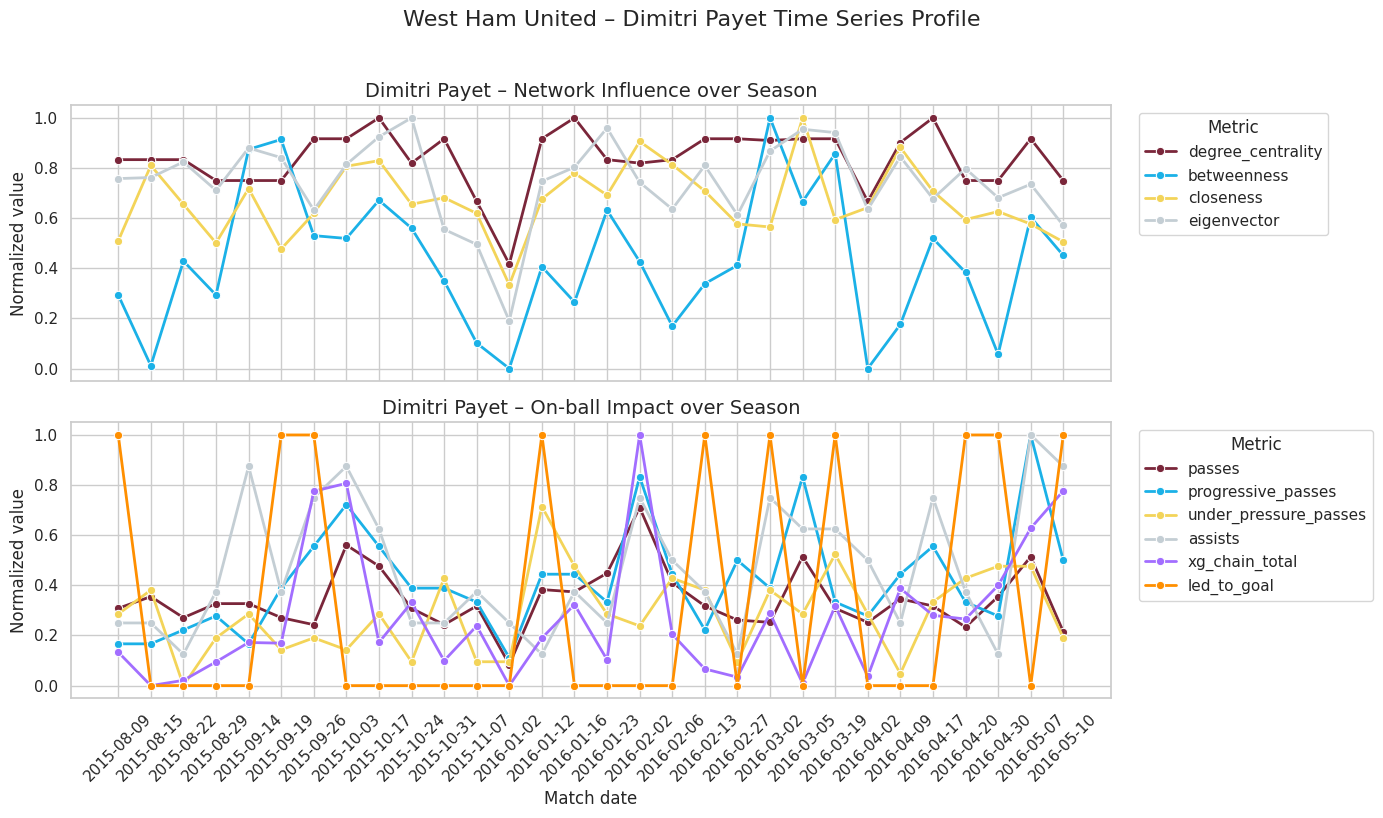

In [45]:
plot_player_timeseries(final_df_norm, "Dimitri Payet",
                       network_metrics, impact_metrics,
                       struct_colors, impact_colors)

## Progression Analysis for Mark Noble

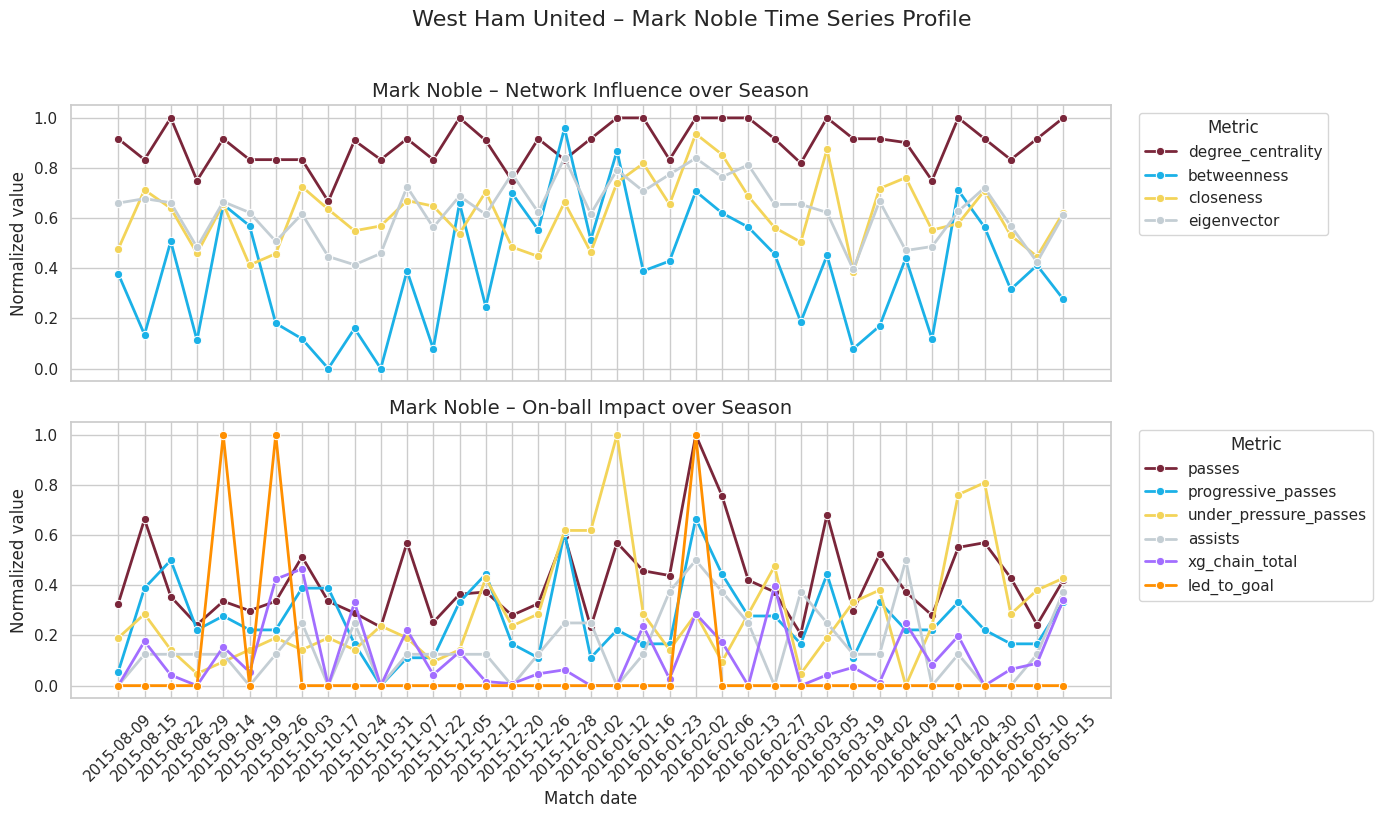

In [46]:
plot_player_timeseries(final_df_norm, "Mark Noble",
                       network_metrics, impact_metrics,
                       struct_colors, impact_colors)

## Progression Analysis for Aaron Cresswell

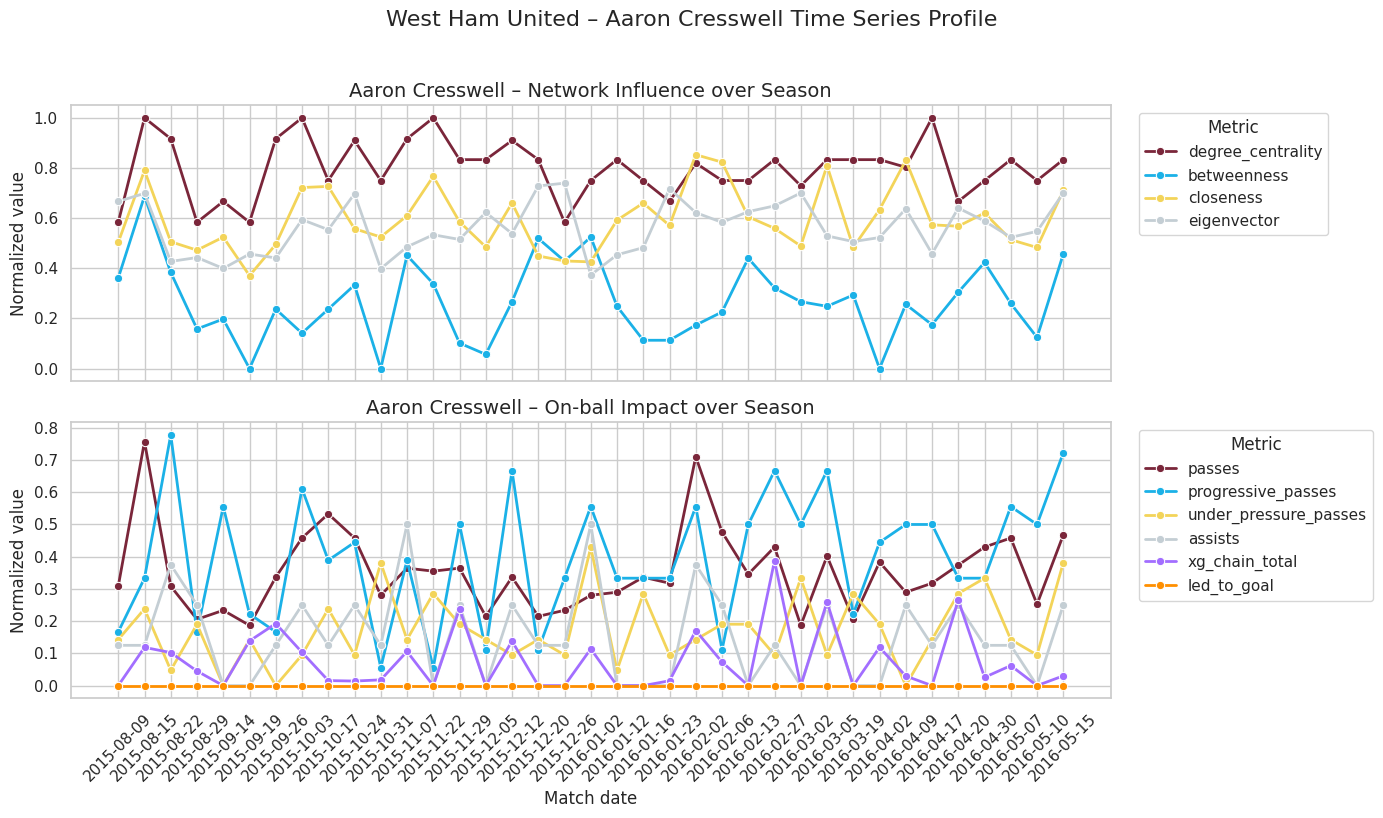

In [47]:
plot_player_timeseries(final_df_norm, "Aaron Cresswell",
                       network_metrics, impact_metrics,
                       struct_colors, impact_colors)

# 8. Dimensionality Reduction & Clustering

PCA-based clustering.

Even without positional tracking data, passing networks + event profiles contain enough signal to infer broad 4 tactical roles.

Different roles naturally cluster:

| Role	| Strong features |
| -- | -- |  
| FB (Fullbacks)	| high volume, moderate progression, wide position, low xG/assists |
| CM (Central Midfielders)	| highest pass volume & centrality (degree / eigenvector) |
| WF	(Wingers) | xG-chain, assists, progressive passes |
| CF (Forwards)	| xG-chain, goal involvement, low centrality |

We can then run PCA on the scaled features and cluster them with KMeans(n_clusters=4).

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

features = [
    "avg_degree", "avg_betweenness", "avg_closeness", "avg_eigenvector",
    "total_passes", "total_progressive", "total_under_pressure",
    "total_assists", "total_xg_chain"
]

X = df[features]

# ---- 1) Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- 2) PCA for interpretability / plotting only
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]
df["pca3"] = X_pca[:, 2]

# ---- 3) KMeans in scaled feature space
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
df["action_cluster"] = kmeans.fit_predict(X_scaled)

# ---- 4) Centroids in feature space (4 x 9)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)

# ---- 5) Role scores per cluster (z-scaling centroids across clusters)
cent_z = (centroids - centroids.mean()) / centroids.std(ddof=0)

# CM: very central + high volume
cm_score = (
    cent_z["total_passes"]
    + cent_z["avg_degree"]
    + cent_z["avg_eigenvector"]
)

# WF: creative wide / chance creator
wf_score = (
    cent_z["total_progressive"]
    + cent_z["total_assists"]
    + cent_z["total_xg_chain"]
)

# CF: finisher – xG chain but relatively low centrality
cf_score = (
    cent_z["total_xg_chain"]
    - 0.5 * cent_z["avg_degree"]
    - 0.5 * cent_z["avg_eigenvector"]
)

# FB: high volume, some progression, low direct xG/assists
fb_score = (
    cent_z["total_passes"]
    + 0.5 * cent_z["total_progressive"]
    - 0.5 * cent_z["total_xg_chain"]
    - 0.5 * cent_z["total_assists"]
)

role_scores = {
    "CM": cm_score,
    "WF": wf_score,
    "CF": cf_score,
    "FB": fb_score,
}

# ---- 6) Greedy non-overlapping assignment: one cluster per role
cluster_map = {}
available = set(range(len(centroids)))  # {0,1,2,3}

for role, scores in role_scores.items():
    # pick best cluster among remaining ones for this role
    best_cluster = scores.loc[list(available)].idxmax()
    cluster_map[best_cluster] = role
    available.remove(best_cluster)

# Map each player’s cluster to a role
df["action_role"] = df["action_cluster"].map(cluster_map)

print("Cluster → role mapping:")
print(cluster_map)
df[["player", "action_cluster", "action_role"]]

Cluster → role mapping:
{np.int64(2): 'CM', np.int64(0): 'WF', np.int64(1): 'CF', np.int64(3): 'FB'}


,player,action_cluster,action_role
4,Dimitri Payet,2,CM
6,Manuel Lanzini,0,WF
10,Mark Noble,2,CM
0,Aaron Cresswell,2,CM
8,Cheikhou Kouyaté,0,WF
12,Diafra Sakho,3,FB
2,Michail Antonio,0,WF
24,Mauro Matías Zárate,3,FB
23,Alexandre Dimitri Song-Billong,3,FB
14,Andy Carroll,3,FB


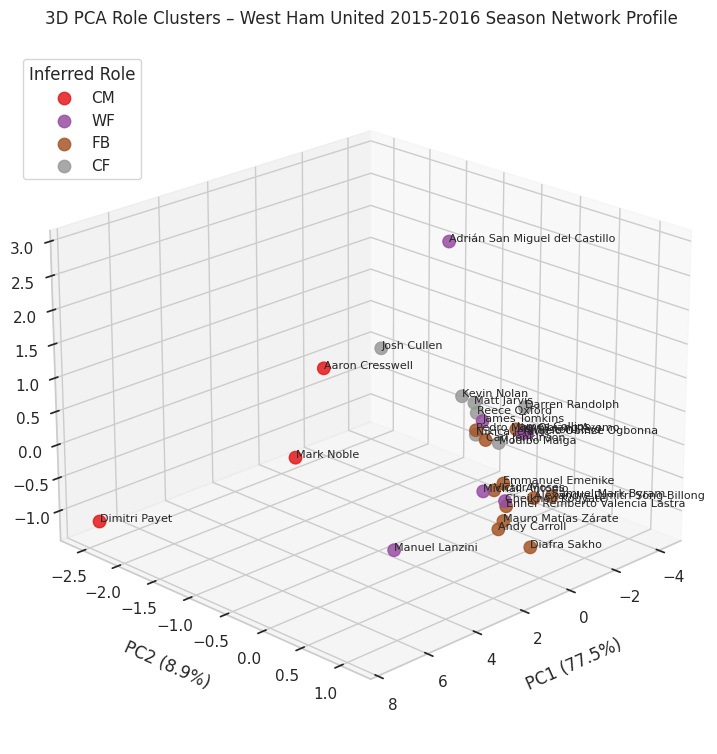

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Make sure PCA object is available (from previous cell)
expl_var = pca.explained_variance_ratio_

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Unique roles
roles = df["action_role"].unique()
colors = plt.cm.Set1(np.linspace(0, 1, len(roles)))
role_color_map = dict(zip(roles, colors))

# Scatter points
for role in roles:
    subset = df[df["action_role"] == role]
    ax.scatter(
        subset["pca1"], subset["pca2"], subset["pca3"],
        color=role_color_map[role],
        label=role, s=80, alpha=0.85
    )

# Add text labels for each player
for _, row in df.iterrows():
    ax.text(
        row["pca1"], row["pca2"], row["pca3"],
        row["player"], size=8, zorder=10
    )

# Axis labels with explained variance
ax.set_xlabel(f"PC1 ({expl_var[0]*100:.1f}%)", labelpad=12)
ax.set_ylabel(f"PC2 ({expl_var[1]*100:.1f}%)", labelpad=12)
ax.set_zlabel(f"PC3 ({expl_var[2]*100:.1f}%)", labelpad=12)

# Camera angle
ax.view_init(elev=22, azim=45)

ax.set_title("3D PCA Role Clusters – West Ham United 2015-2016 Season Network Profile", pad=20)
ax.legend(title="Inferred Role", loc="upper left")

plt.show()

# 9. Conclusion & Next Steps

## Conclusion

This research successfully answered all the key questions posed at the outset. By combining network-based centrality metrics with event-level passing and xG-chain features, we were able to quantitatively identify which West Ham United players exerted the greatest influence in possession, who most effectively progressed play under pressure, and which individuals were consistently involved in goal-chain or xG-chain sequences. These insights extend beyond traditional match statistics by capturing structural impact—how players connect, drive, and shape the team’s possession network.

Furthermore, applying PCA and clustering to season-long features allowed us to infer functional player roles directly from data. This demonstrates how network analytics and machine-learning methods can summarize complex player behaviour into interpretable, role-based profiles.

Overall, this methodological pipeline is broadly applicable for clubs beyond the elite tier. It provides a scalable, objective framework for identifying undervalued talent in medium-visibility leagues by quantifying tactical influence, progression ability, and chance-creation involvement. Such metrics can support scouting teams and decision-makers with a deeper evidence-based understanding of player contribution and future potential.

## Next Steps

#### **1. Time-Adjusted Network Metrics**

As a future enhancement, the network metrics (centralities and pass-based counts) could be normalised by minutes played to provide a fair comparison across players with different playing time.

At the moment, centralities are computed purely from the match graph structure, so they reflect tactical role and connectivity rather than per-minute influence. However, for season-long comparison—especially when contrasting starters with frequent substitutes—it may be beneficial to convert pass volumes, progressive actions, assists, and even derived goal-chain metrics into per-90 values.

This would ensure that player rankings reflect impact rate rather than total accumulation. For this stage of the analysis, I intentionally avoided applying time-scaling to keep the structural network interpretation pure, but incorporating minutes-adjusted metrics would be a strong next step.

#### **2. With this data, we can derive role-based categories (FB, CM, WF, CF) from positional heatmaps**

We can compute for each player:

- mean pass start location (sx, sy)

- mean pass end location (ex, ey)

Then define:

- avg_field_position = mean([sx, ex]), mean([sy, ey])

- From positional heatmaps you can classify:

Role	Typical location:
- FB (Fullbacks)	deeper, wide (x < 60, y near touchline)
- WF (Wingers)	advanced, wide (x > 60, y near touchline)
- CM (Central Midfielders)	central corridor (30 < x < 70, 25 < y < 55)
- CF (Forwards)	highest players (x > 75, middle lanes)